In [147]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier

In [406]:
diabetes = pd.read_csv('/Users/ruyuliu/Desktop/DeepLearningSELF/PYTORCH_NOTEBOOKS/Assignment1/diabetes.csv')
diabetes = shuffle(diabetes)
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
304,3,150,76,0,0,21.0,0.207,37,0
106,1,96,122,0,0,22.4,0.207,27,0
466,0,74,52,10,36,27.8,0.269,22,0
56,7,187,68,39,304,37.7,0.254,41,1
545,8,186,90,35,225,34.5,0.423,37,1


In [408]:
print(diabetes.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [409]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 768 entries, 304 to 43
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


In [3]:
# continue variables columns
cont_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 
             'SkinThickness', 'Insulin','BMI', 
             'DiabetesPedigreeFunction', 'Age']

# label column
y_col = ['Outcome']  

In [5]:
# Convert continuous variables to a tensor
conts = np.stack([diabetes[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)

# Convert labels to a tensor
y = torch.tensor(diabetes[y_col].values).flatten()

In [157]:
class ReLUModel(nn.Module):
    
    def __init__(self,n_cont,out_sz,layers,p=0.5):
        
        
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_in = n_cont
        
        # set up layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        # the last layer with output size    
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # combine the list of layers with torch.nn.Sequential()
        self.layers = nn.Sequential(*layerlist)
    
    
    def forward(self, x):
        
        x = self.bn_cont(x)
        x = self.layers(x)
        
        return x

In [158]:
class TanhModel(nn.Module):
    
    def __init__(self,n_cont,out_sz,layers,p=0.5):
        
        
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_in = n_cont
        
        # set up layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.Tanh())
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        # the last layer with output size    
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # combine the list of layers with torch.nn.Sequential()
        self.layers = nn.Sequential(*layerlist)
    
    
    def forward(self, x):
        
        x = self.bn_cont(x)
        x = self.layers(x)
        
        return x

In [159]:
batch_size = 768
val_size = int(batch_size*0.2)
test_size = int(batch_size*0.2)

con_train = conts[:batch_size-val_size-test_size]
con_vald = conts[batch_size-val_size-test_size:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

y_train = y[:batch_size-val_size-test_size]
y_vald = y[batch_size-val_size-test_size:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

epoch:   1  loss: 0.68383080
epoch: 101  loss: 0.50579691
epoch: 201  loss: 0.47428200
epoch: 301  loss: 0.43643498
epoch: 400  loss: 0.43947330

Duration: 0 seconds
Validation Loss: 0.52494663

122 out of 153 = 79.74% correct on validation set
Accuracy: 0.7973856209150327
Precision: 0.5740740740740741
Recall: 0.7948717948717948
F1 SCORE: 0.6666666666666666


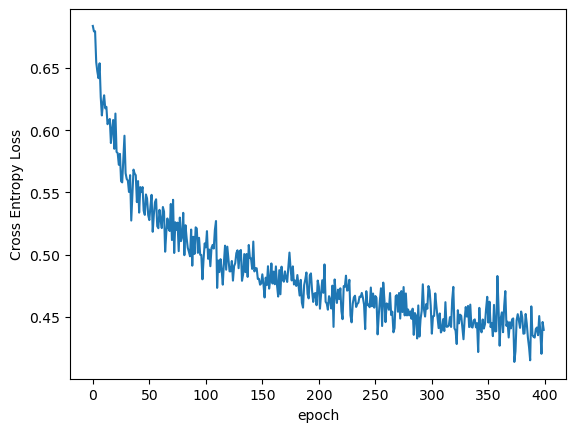

In [390]:
# single-layer with 32 neurons,RELU

torch.manual_seed(33)
sl_rmodel_32 = ReLUModel(conts.shape[1], 2,[32],0.4) 

import time
start_time = time.time()

epochs = 400
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sl_rmodel_32.parameters(), lr=0.001)


for i in range(epochs):
    i+=1
    y_pred = sl_rmodel_32(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = sl_rmodel_32(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.81756085
epoch: 201  loss: 0.61065793
epoch: 401  loss: 0.54553568
epoch: 601  loss: 0.51527840
epoch: 801  loss: 0.51702452
epoch: 1001  loss: 0.46712098
epoch: 1201  loss: 0.47481036
epoch: 1401  loss: 0.46747893
epoch: 1601  loss: 0.45679319
epoch: 1801  loss: 0.45121816
epoch: 2001  loss: 0.44413051
epoch: 2200  loss: 0.45132098

Duration: 3 seconds
Validation Loss: 0.46983680

128 out of 153 = 83.66% correct on validation set
Accuracy: 0.8366013071895425
Precision: 0.6666666666666666
Recall: 0.717948717948718
F1 SCORE: 0.691358024691358


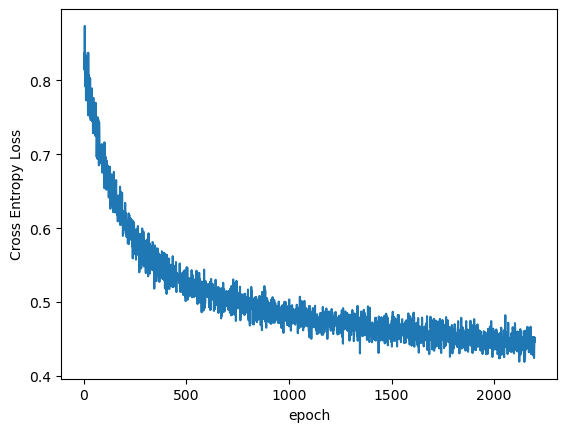

In [404]:
# single-layer with 64 neurons,RELU
torch.manual_seed(33)
sl_rmodel_64 = ReLUModel(conts.shape[1], 2, [64],0.4) 

import time
start_time = time.time()

epochs = 2200
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sl_rmodel_64.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 500, 800, 1500], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = sl_rmodel_64(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%200 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = sl_rmodel_64(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 1.14814496
epoch: 501  loss: 0.89075696
epoch: 1001  loss: 0.75346029
epoch: 1501  loss: 0.66209668
epoch: 2001  loss: 0.62186414
epoch: 2501  loss: 0.58919561
epoch: 3001  loss: 0.57110769
epoch: 3501  loss: 0.53191036
epoch: 4001  loss: 0.52862698
epoch: 4501  loss: 0.51335049
epoch: 5000  loss: 0.50460583

Duration: 9 seconds
Validation Loss: 0.52250051

119 out of 153 = 77.78% correct on validation test
Accuracy: 0.7777777777777778
Precision: 0.543859649122807
Recall: 0.7948717948717948
F1 SCORE: 0.6458333333333333


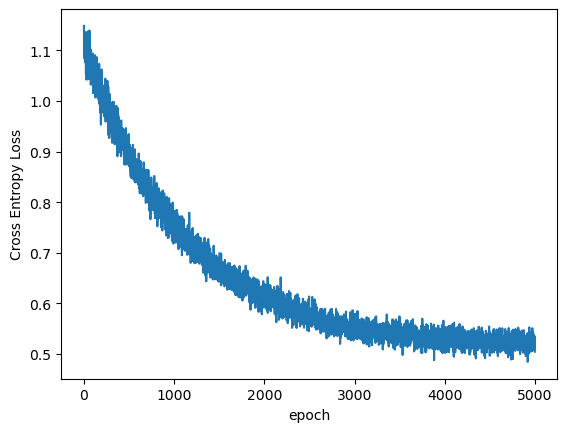

In [313]:
# single-layer with 128 neurons, RELU
torch.manual_seed(33)
sl_rmodel_128 = ReLUModel(conts.shape[1], 2, [128],0.4) 

import time
start_time = time.time()

epochs = 5000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sl_rmodel_128.parameters(), lr=0.00001)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3000, 4000, 5000, 6000], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = sl_rmodel_128(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%500 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

# to evaluate on the validation set
with torch.no_grad():
    y_val = sl_rmodel_128(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')


rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation test')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.84791195
epoch: 501  loss: 0.64148086
epoch: 1001  loss: 0.56413537
epoch: 1501  loss: 0.53996617
epoch: 2001  loss: 0.52292854
epoch: 2501  loss: 0.53575575
epoch: 3001  loss: 0.52162826
epoch: 3501  loss: 0.51927060
epoch: 4001  loss: 0.51496828
epoch: 4501  loss: 0.51340461
epoch: 5000  loss: 0.48760921

Duration: 12 seconds
Validation Loss: 0.52461451

120 out of 153 = 78.43% correct on validation test
Accuracy: 0.7843137254901961
Precision: 0.5535714285714286
Recall: 0.7948717948717948
F1 SCORE: 0.6526315789473683


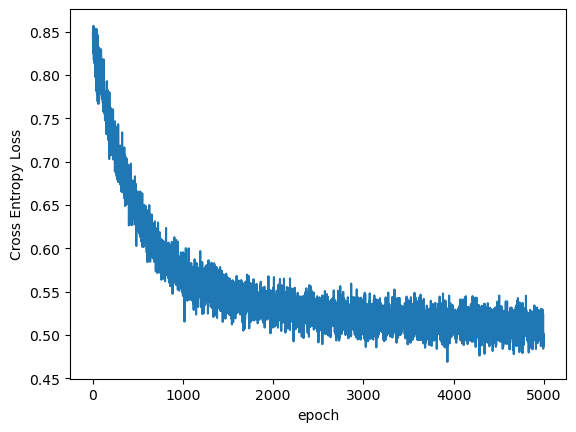

In [315]:
# single-layer with 256 neurons, RELU
torch.manual_seed(33)
sl_rmodel_256 = ReLUModel(conts.shape[1], 2, [256],0.4) 

import time
start_time = time.time()

epochs = 5000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sl_rmodel_256.parameters(), lr=0.00001)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000, 2000, 3000, 4000], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = sl_rmodel_256(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%500 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

# to evaluate on the validation set
with torch.no_grad():
    y_val = sl_rmodel_256(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')


rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation test')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.71134764
epoch:  51  loss: 0.54664063
epoch: 101  loss: 0.52024060
epoch: 151  loss: 0.50328380
epoch: 201  loss: 0.50743228
epoch: 251  loss: 0.51115066
epoch: 301  loss: 0.48530093
epoch: 351  loss: 0.50054359
epoch: 401  loss: 0.49336407
epoch: 451  loss: 0.49466664
epoch: 500  loss: 0.50215864

Duration: 0 seconds
Validation Loss: 0.46606773

124 out of 153 = 81.05% correct on validation test
Accuracy: 0.8104575163398693
Precision: 0.5961538461538461
Recall: 0.7948717948717948
F1 SCORE: 0.6813186813186813


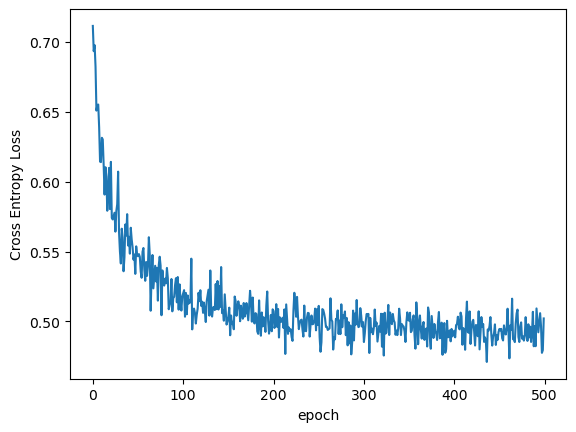

In [316]:
# single-layer with 32 neurons, TANH
torch.manual_seed(33)
sl_tmodel_32 = TanhModel(conts.shape[1], 2, [32],0.4) 

import time
start_time = time.time()

epochs = 500
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sl_tmodel_32.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 300, 400], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = sl_tmodel_32(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%50 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

# to evaluate on the validation set
with torch.no_grad():
    y_val = sl_tmodel_32(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')


rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation test')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.79843611
epoch:  51  loss: 0.69969010
epoch: 101  loss: 0.66697669
epoch: 151  loss: 0.59668136
epoch: 201  loss: 0.57214618
epoch: 251  loss: 0.55523986
epoch: 301  loss: 0.54701877
epoch: 351  loss: 0.53568745
epoch: 401  loss: 0.54554230
epoch: 451  loss: 0.52357841
epoch: 501  loss: 0.52538204
epoch: 551  loss: 0.51852691
epoch: 601  loss: 0.51994848
epoch: 651  loss: 0.51921546
epoch: 701  loss: 0.51430988
epoch: 751  loss: 0.52007979
epoch: 801  loss: 0.51625293
epoch: 851  loss: 0.48803613
epoch: 901  loss: 0.49406838
epoch: 951  loss: 0.51397681
epoch: 1000  loss: 0.51318276

Duration: 1 seconds
Validation Loss: 0.44063213

127 out of 153 = 83.01% correct on validation set
Accuracy: 0.8300653594771242
Precision: 0.6274509803921569
Recall: 0.8205128205128205
F1 SCORE: 0.711111111111111


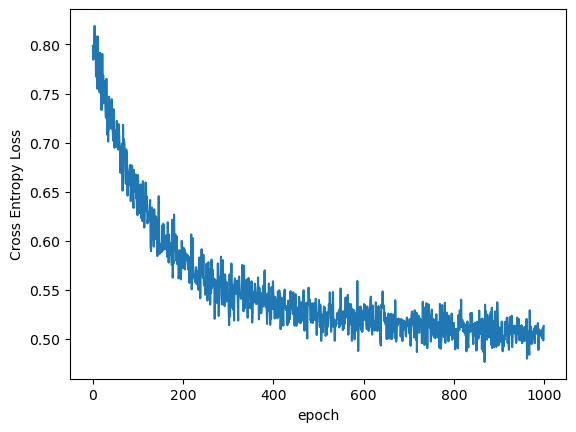

In [317]:
# single-layer with 64 neurons, TANH
torch.manual_seed(33)
sl_tmodel_64 = TanhModel(conts.shape[1], 2, [64],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sl_tmodel_64.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 60, 80], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = sl_tmodel_64(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = sl_tmodel_64(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 1.22719443
epoch: 101  loss: 0.76849669
epoch: 201  loss: 0.59930533
epoch: 301  loss: 0.54750687
epoch: 401  loss: 0.54136711
epoch: 501  loss: 0.52320212
epoch: 601  loss: 0.50551450
epoch: 701  loss: 0.52042824
epoch: 801  loss: 0.50895864
epoch: 901  loss: 0.49942079
epoch: 1000  loss: 0.47573784

Duration: 2 seconds
Validation Loss: 0.47227642

124 out of 153 = 81.05% correct on validation set
Accuracy: 0.8104575163398693
Precision: 0.5925925925925926
Recall: 0.8205128205128205
F1 SCORE: 0.6881720430107526


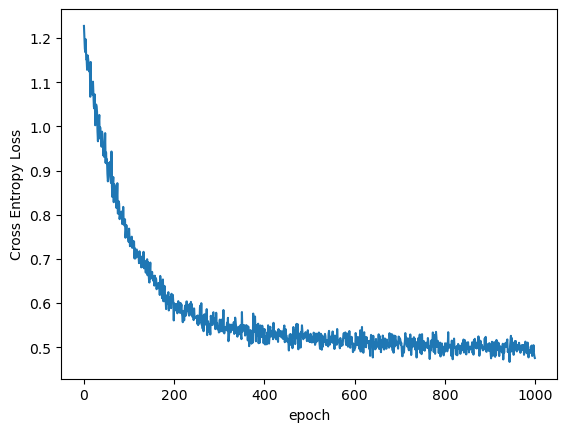

In [394]:
# single-layer with 128 neurons, TANH
torch.manual_seed(33)
sl_tmodel_128 = TanhModel(conts.shape[1], 2, [128],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sl_tmodel_128.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 600, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = sl_tmodel_128(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = sl_tmodel_128(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')

print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.88102055
epoch: 101  loss: 0.63980830
epoch: 201  loss: 0.57224119
epoch: 301  loss: 0.53034461
epoch: 401  loss: 0.50543809
epoch: 501  loss: 0.52208239
epoch: 601  loss: 0.50789285
epoch: 701  loss: 0.51958978
epoch: 801  loss: 0.50933170
epoch: 901  loss: 0.49135578
epoch: 1000  loss: 0.49574086

Duration: 4 seconds
Validation Loss: 0.44284126

127 out of 153 = 83.01% correct on validation set
Accuracy: 0.8300653594771242
Precision: 0.6326530612244898
Recall: 0.7948717948717948
F1 SCORE: 0.7045454545454547


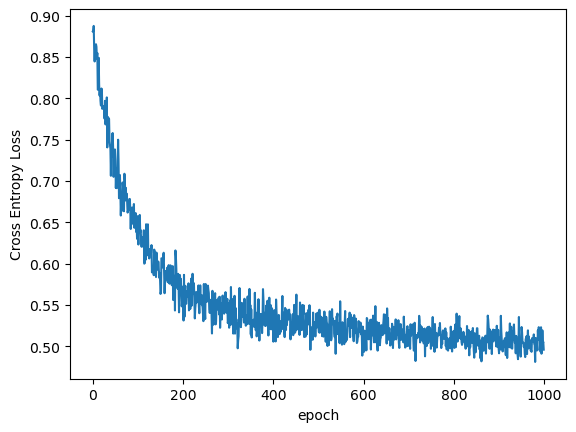

In [400]:
# single-layer with 256 neurons
torch.manual_seed(33)
sl_tmodel_256 = TanhModel(conts.shape[1], 2, [256],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sl_tmodel_256.parameters(), lr=0.00005)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 70, 100, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = sl_tmodel_256(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = sl_tmodel_256(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')

print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.87170458
epoch: 201  loss: 0.63106936
epoch: 401  loss: 0.54404086
epoch: 601  loss: 0.53707081
epoch: 801  loss: 0.51173162
epoch: 1000  loss: 0.49552685

Duration: 2 seconds
Validation Loss: 0.50760937

116 out of 153 = 75.82% correct on validation set
Accuracy: 0.7581699346405228
Precision: 0.5185185185185185
Recall: 0.717948717948718
F1 SCORE: 0.6021505376344085


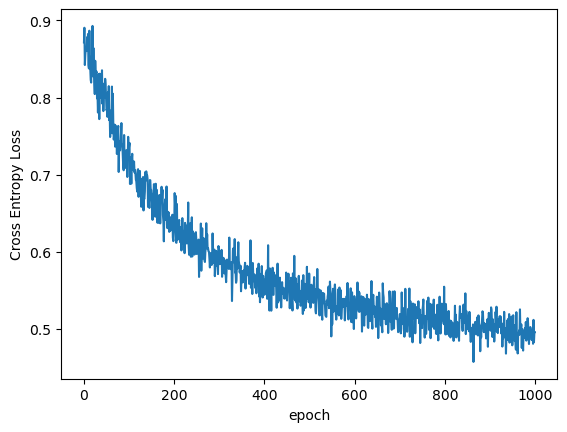

In [338]:
torch.manual_seed(33)
ml_rmodel_32 = ReLUModel(conts.shape[1], 2, [32,32],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_rmodel_32.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_rmodel_32(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%200 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_rmodel_32(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.76370770
epoch: 101  loss: 0.64076543
epoch: 201  loss: 0.56723189
epoch: 301  loss: 0.56831843
epoch: 401  loss: 0.52726668
epoch: 501  loss: 0.52124804
epoch: 601  loss: 0.49066165
epoch: 701  loss: 0.48029187
epoch: 801  loss: 0.49986845
epoch: 901  loss: 0.52128971
epoch: 1000  loss: 0.49969089

Duration: 2 seconds
Validation Loss: 0.46520337

127 out of 153 = 83.01% correct on validation set
Accuracy: 0.8300653594771242
Precision: 0.6326530612244898
Recall: 0.7948717948717948
F1 SCORE: 0.7045454545454547


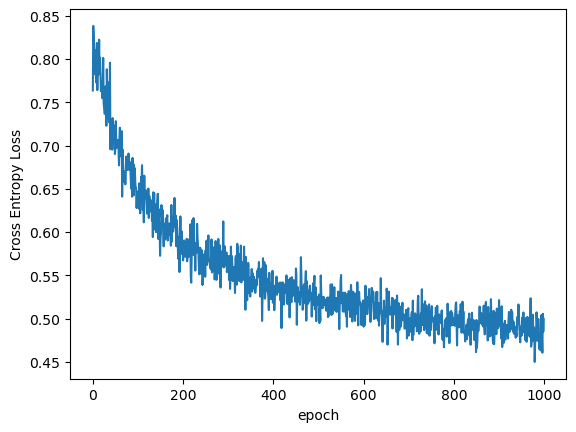

In [339]:
torch.manual_seed(33)
ml_rmodel_3264 = ReLUModel(conts.shape[1], 2, [32,64],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_rmodel_3264.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_rmodel_3264(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_rmodel_3264(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')

print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.87216198
epoch: 101  loss: 0.59366888
epoch: 201  loss: 0.55117524
epoch: 301  loss: 0.53990018
epoch: 401  loss: 0.48576322
epoch: 501  loss: 0.49606419
epoch: 601  loss: 0.48320910
epoch: 701  loss: 0.49925089
epoch: 801  loss: 0.48802888
epoch: 901  loss: 0.46657157
epoch: 1000  loss: 0.43806764

Duration: 2 seconds
Validation Loss: 0.53165483

119 out of 153 = 77.78% correct on validation set
Accuracy: 0.7777777777777778
Precision: 0.5510204081632653
Recall: 0.6923076923076923
F1 SCORE: 0.6136363636363635


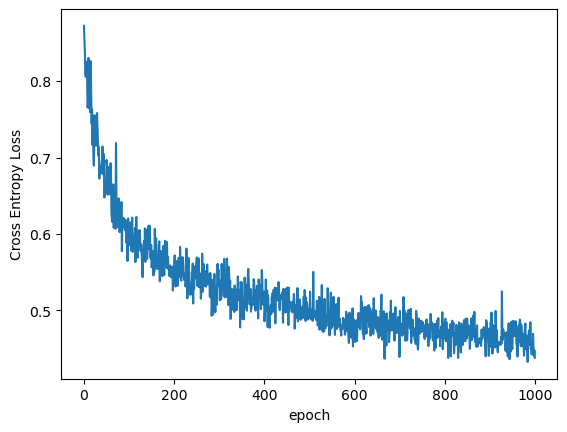

In [335]:
torch.manual_seed(33)
ml_rmodel_64 = ReLUModel(conts.shape[1], 2, [64,64],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_rmodel_64.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_rmodel_64(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_rmodel_64(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.74988776
epoch: 101  loss: 0.63442540
epoch: 201  loss: 0.60991907
epoch: 301  loss: 0.60228258
epoch: 401  loss: 0.56325179
epoch: 501  loss: 0.56039757
epoch: 601  loss: 0.56729466
epoch: 701  loss: 0.54861754
epoch: 800  loss: 0.54567975

Duration: 2 seconds
Validation Loss: 0.55673647

116 out of 153 = 75.82% correct on validation set
Accuracy: 0.7581699346405228
Precision: 0.515625
Recall: 0.8461538461538461
F1 SCORE: 0.6407766990291262


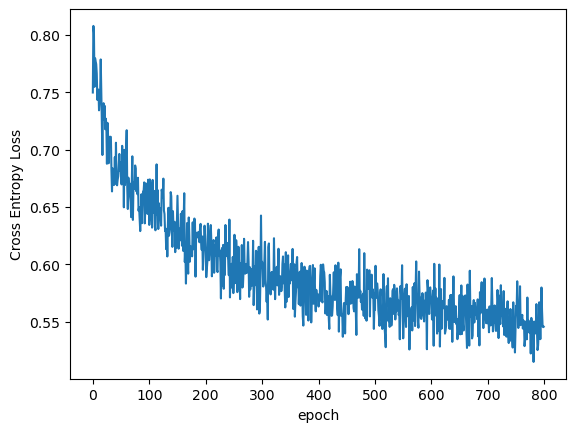

In [342]:
torch.manual_seed(33)
ml_rmodel_64128 = ReLUModel(conts.shape[1], 2, [64,128],0.4) 

import time
start_time = time.time()

epochs = 800
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_rmodel_64128.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)



for i in range(epochs):
    i+=1
    y_pred = ml_rmodel_64128(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_rmodel_64128(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.89206731
epoch: 101  loss: 0.59698743
epoch: 201  loss: 0.55704689
epoch: 301  loss: 0.55456823
epoch: 401  loss: 0.49869847
epoch: 501  loss: 0.49728116
epoch: 601  loss: 0.50403780
epoch: 701  loss: 0.49285990
epoch: 800  loss: 0.47361928

Duration: 3 seconds
Validation Loss: 0.51564604

118 out of 153 = 77.12% correct on validation set
Accuracy: 0.7712418300653595
Precision: 0.532258064516129
Recall: 0.8461538461538461
F1 SCORE: 0.6534653465346534


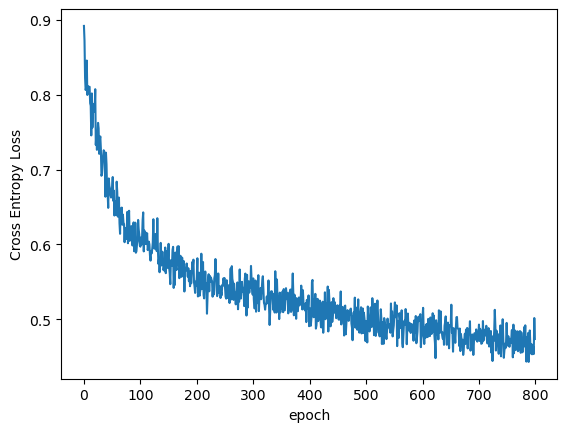

In [345]:
torch.manual_seed(33)
ml_rmodel_128 = ReLUModel(conts.shape[1], 2, [128,128],0.4) 

import time
start_time = time.time()

epochs = 800
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_rmodel_128.parameters(), lr=0.00005)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)



for i in range(epochs):
    i+=1
    y_pred = ml_rmodel_128(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_rmodel_128(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.89510858
epoch: 101  loss: 0.57159299
epoch: 201  loss: 0.52175802
epoch: 301  loss: 0.49540997
epoch: 401  loss: 0.50669396
epoch: 501  loss: 0.46871886
epoch: 601  loss: 0.48143300
epoch: 701  loss: 0.43976596
epoch: 800  loss: 0.42460218

Duration: 4 seconds
Validation Loss: 0.55165493

121 out of 153 = 79.08% correct on validation set
Accuracy: 0.7908496732026143
Precision: 0.5573770491803278
Recall: 0.8717948717948718
F1 SCORE: 0.6799999999999999


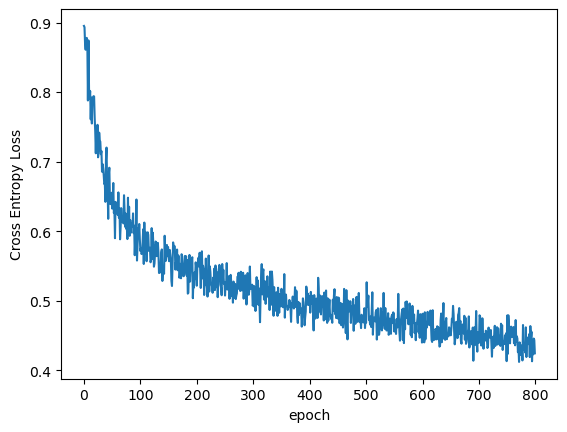

In [347]:
torch.manual_seed(33)
ml_rmodel_128256 = ReLUModel(conts.shape[1], 2, [128,256],0.4) 

import time
start_time = time.time()

epochs = 800
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_rmodel_128256.parameters(), lr=0.00005)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)



for i in range(epochs):
    i+=1
    y_pred = ml_rmodel_128256(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_rmodel_128256(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.79076093
epoch: 101  loss: 0.53229147
epoch: 201  loss: 0.50554621
epoch: 301  loss: 0.46862051
epoch: 401  loss: 0.45533943
epoch: 501  loss: 0.43155465
epoch: 601  loss: 0.41846567
epoch: 701  loss: 0.40957206
epoch: 800  loss: 0.37254182

Duration: 3 seconds
Validation Loss: 0.56402385

119 out of 153 = 77.78% correct on validation set
Accuracy: 0.7777777777777778
Precision: 0.5471698113207547
Recall: 0.7435897435897436
F1 SCORE: 0.6304347826086957


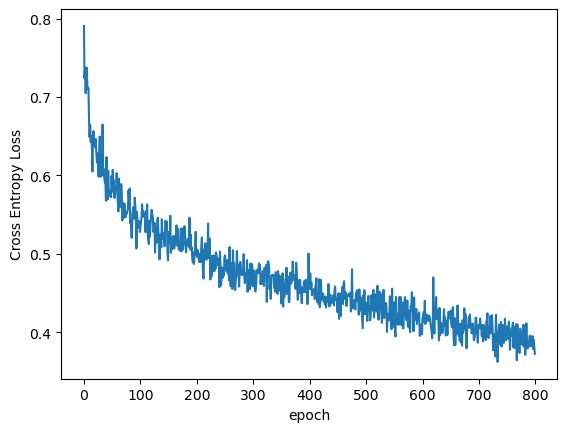

In [354]:
torch.manual_seed(33)
ml_rmodel_256 = ReLUModel(conts.shape[1], 2, [256,256],0.4) 

import time
start_time = time.time()

epochs = 800
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_rmodel_256.parameters(), lr=0.00005)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)



for i in range(epochs):
    i+=1
    y_pred = ml_rmodel_256(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_rmodel_256(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')

print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.87565982
epoch: 101  loss: 0.70069903
epoch: 201  loss: 0.60841203
epoch: 301  loss: 0.55823123
epoch: 401  loss: 0.56043422
epoch: 501  loss: 0.55164957
epoch: 601  loss: 0.55539352
epoch: 701  loss: 0.53518814
epoch: 801  loss: 0.53167355
epoch: 901  loss: 0.52812546
epoch: 1000  loss: 0.51207674

Duration: 2 seconds
Validation Loss: 0.50747812

118 out of 153 = 77.12% correct on validation set
Accuracy: 0.7712418300653595
Precision: 0.5333333333333333
Recall: 0.8205128205128205
F1 SCORE: 0.6464646464646464


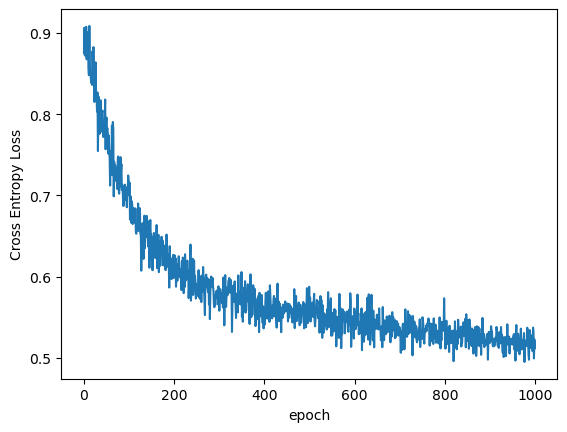

In [355]:
torch.manual_seed(33)
ml_tmodel_32 = TanhModel(conts.shape[1], 2, [32,32],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_tmodel_32.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_tmodel_32(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_tmodel_32(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.72019160
epoch: 101  loss: 0.59569407
epoch: 201  loss: 0.56437582
epoch: 301  loss: 0.55262166
epoch: 401  loss: 0.53176928
epoch: 501  loss: 0.54826415
epoch: 601  loss: 0.51559538
epoch: 701  loss: 0.51107889
epoch: 800  loss: 0.51613450

Duration: 2 seconds
Validation Loss: 0.47326764

121 out of 153 = 79.08% correct on validation set
Accuracy: 0.7908496732026143
Precision: 0.5686274509803921
Recall: 0.7435897435897436
F1 SCORE: 0.6444444444444445


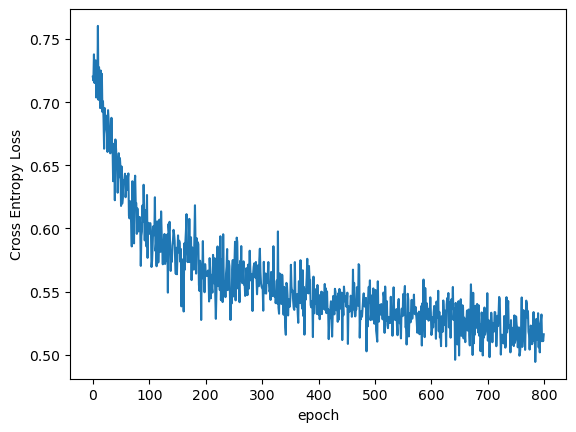

In [401]:
torch.manual_seed(33)
ml_tmodel_3264 = TanhModel(conts.shape[1], 2, [32,64],0.4) 

import time
start_time = time.time()

epochs = 800
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_tmodel_3264.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_tmodel_3264(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_tmodel_3264(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.92259568
epoch: 101  loss: 0.64122212
epoch: 201  loss: 0.59189165
epoch: 301  loss: 0.61173648
epoch: 401  loss: 0.55620503
epoch: 501  loss: 0.55537355
epoch: 601  loss: 0.53172630
epoch: 701  loss: 0.56232375
epoch: 801  loss: 0.55033594
epoch: 901  loss: 0.54625523
epoch: 1000  loss: 0.51359028

Duration: 3 seconds
Validation Loss: 0.54039371

115 out of 153 = 75.16% correct on validation set
Accuracy: 0.7516339869281046
Precision: 0.5079365079365079
Recall: 0.8205128205128205
F1 SCORE: 0.6274509803921569


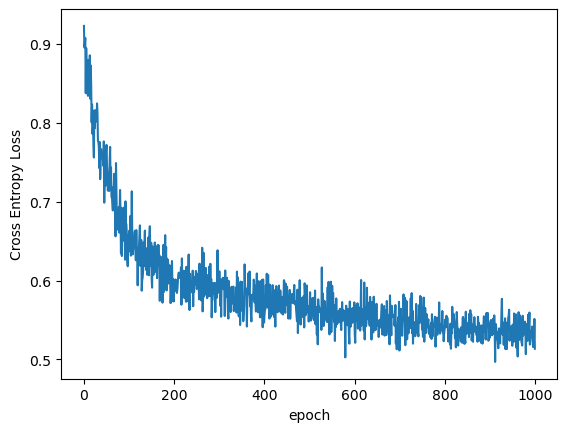

In [377]:
torch.manual_seed(33)
ml_tmodel_64 = TanhModel(conts.shape[1], 2, [64,64],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_tmodel_64.parameters(), lr=0.00005)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_tmodel_64(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_tmodel_64(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.74852979
epoch: 101  loss: 0.56040645
epoch: 201  loss: 0.56472403
epoch: 301  loss: 0.56212753
epoch: 401  loss: 0.51680368
epoch: 501  loss: 0.52697271
epoch: 601  loss: 0.51391983
epoch: 701  loss: 0.50469923
epoch: 801  loss: 0.51265830
epoch: 901  loss: 0.50457013
epoch: 1000  loss: 0.49764273

Duration: 2 seconds
Validation Loss: 0.46851459

124 out of 153 = 81.05% correct on validation set
Accuracy: 0.8104575163398693
Precision: 0.6
Recall: 0.7692307692307693
F1 SCORE: 0.6741573033707865


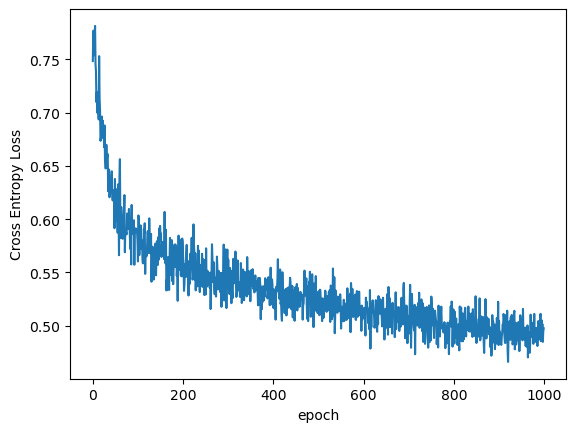

In [365]:
torch.manual_seed(33)
ml_tmodel_64128 = TanhModel(conts.shape[1], 2, [64,128],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_tmodel_64128.parameters(), lr=0.0001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_tmodel_64128(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_tmodel_64128(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')

print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.89380252
epoch: 101  loss: 0.71085793
epoch: 201  loss: 0.66134191
epoch: 301  loss: 0.62056327
epoch: 401  loss: 0.62714642
epoch: 501  loss: 0.58926320
epoch: 601  loss: 0.61167562
epoch: 701  loss: 0.59085315
epoch: 801  loss: 0.60498571
epoch: 901  loss: 0.57699341
epoch: 1001  loss: 0.57475865
epoch: 1101  loss: 0.58790451
epoch: 1201  loss: 0.55911618
epoch: 1301  loss: 0.55100441
epoch: 1401  loss: 0.55691564
epoch: 1501  loss: 0.53991675
epoch: 1601  loss: 0.52211881
epoch: 1701  loss: 0.55045187
epoch: 1801  loss: 0.54570258
epoch: 1901  loss: 0.55672431
epoch: 2000  loss: 0.53492361

Duration: 8 seconds
Validation Loss: 0.53530443

117 out of 153 = 76.47% correct on validation set
Accuracy: 0.7647058823529411
Precision: 0.5211267605633803
Recall: 0.9487179487179487
F1 SCORE: 0.6727272727272727


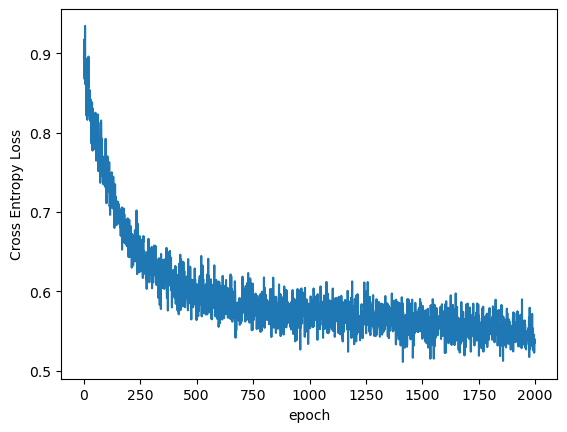

In [368]:
torch.manual_seed(33)
ml_tmodel_128 = TanhModel(conts.shape[1], 2, [128,128],0.4) 

import time
start_time = time.time()

epochs = 2000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_tmodel_128.parameters(), lr=0.00001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_tmodel_128(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_tmodel_128(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.96397221
epoch: 101  loss: 0.56905031
epoch: 201  loss: 0.56287229
epoch: 301  loss: 0.56204766
epoch: 401  loss: 0.54904485
epoch: 501  loss: 0.52568871
epoch: 601  loss: 0.54061443
epoch: 701  loss: 0.50614685
epoch: 801  loss: 0.53392678
epoch: 901  loss: 0.48932904
epoch: 1000  loss: 0.48896566

Duration: 6 seconds
Validation Loss: 0.48723149

117 out of 153 = 76.47% correct on validation set
Accuracy: 0.7647058823529411
Precision: 0.5238095238095238
Recall: 0.8461538461538461
F1 SCORE: 0.6470588235294118


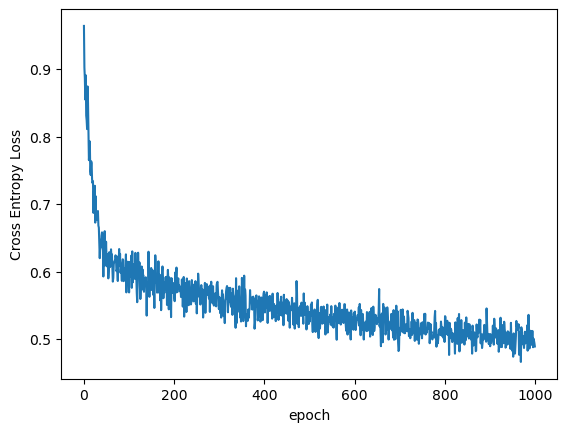

In [371]:
torch.manual_seed(33)
ml_tmodel_128256 = TanhModel(conts.shape[1], 2, [128,256],0.4) 

import time
start_time = time.time()

epochs = 1000
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_tmodel_128256.parameters(), lr=0.00005)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_tmodel_128256(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_tmodel_128256(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')


print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

epoch:   1  loss: 0.80529171
epoch: 101  loss: 0.58935571
epoch: 201  loss: 0.59639949
epoch: 301  loss: 0.57824028
epoch: 401  loss: 0.59642869
epoch: 501  loss: 0.56076854
epoch: 600  loss: 0.54428005

Duration: 4 seconds
Validation Loss: 0.62601668

108 out of 153 = 70.59% correct on validation set
Accuracy: 0.7058823529411765
Precision: 0.4594594594594595
Recall: 0.8717948717948718
F1 SCORE: 0.6017699115044248


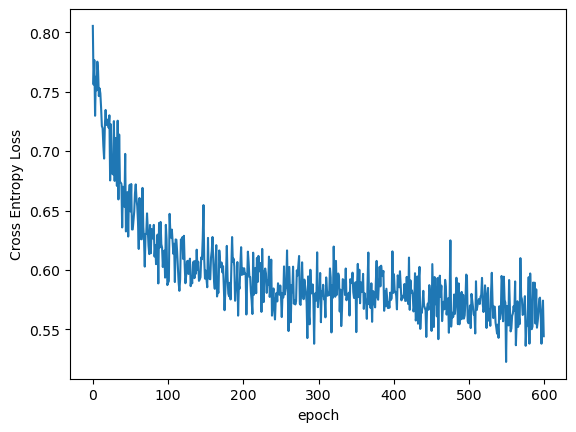

In [376]:
torch.manual_seed(33)
ml_tmodel_256 = TanhModel(conts.shape[1], 2, [256,256],0.4) 

import time
start_time = time.time()

epochs = 600
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ml_tmodel_256.parameters(), lr=0.00001)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 400, 800], gamma=0.5, last_epoch=-1)


for i in range(epochs):
    i+=1
    y_pred = ml_tmodel_256(con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');


# to evaluate on the validation set
with torch.no_grad():
    y_val = ml_tmodel_256(con_vald)
    loss = criterion(y_val, y_vald)
print(f'Validation Loss: {loss:.8f}')

rows = val_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_vald[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on validation set')

print("Accuracy:",metrics.accuracy_score(y_vald.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_vald.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_vald.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_vald.numpy(), y_valuation))

**Traditional Machine Learning: SVM**

In [378]:
# SVM with Linear Kernel

#Create a svm Classifier
clf = svm.SVC(kernel='linear') 

#Train the model using the training sets
clf.fit(con_train, y_train)

#Predict the response for test dataset
y_val = clf.predict(con_vald)


# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald, y_val))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald, y_val))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald, y_val))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald, y_val))

Accuracy: 0.8300653594771242
Precision: 0.6756756756756757
Recall: 0.6410256410256411
F1 SCORE: 0.6578947368421052


In [379]:
# SVM with RBF Kernel
#Create a svm Classifier
clf = svm.SVC(kernel='rbf')

#Train the model using the training sets
clf.fit(con_train, y_train)

#Predict the response for test dataset
y_val = clf.predict(con_vald)


# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald, y_val))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald, y_val))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald, y_val))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald, y_val))

Accuracy: 0.8235294117647058
Precision: 0.6666666666666666
Recall: 0.6153846153846154
F1 SCORE: 0.64


In [380]:
# SVM with poly Kernel
#Create a svm Classifier
clf = svm.SVC(kernel='poly')

#Train the model using the training sets
clf.fit(con_train, y_train)

#Predict the response for test dataset
y_val = clf.predict(con_vald)


# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald, y_val))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald, y_val))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald, y_val))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald, y_val))

Accuracy: 0.8169934640522876
Precision: 0.6774193548387096
Recall: 0.5384615384615384
F1 SCORE: 0.6


**Traditional Machine Learning: KNN**

In [381]:
# K = 5

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(con_train, y_train)
y_val = knn.predict(con_vald)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald, y_val))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald, y_val))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald, y_val))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald, y_val))

Accuracy: 0.7647058823529411
Precision: 0.5294117647058824
Recall: 0.6923076923076923
F1 SCORE: 0.5999999999999999


In [382]:
# K = 10

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(con_train, y_train)
y_val = knn.predict(con_vald)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald, y_val))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald, y_val))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald, y_val))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald, y_val))

Accuracy: 0.8235294117647058
Precision: 0.65
Recall: 0.6666666666666666
F1 SCORE: 0.6582278481012659


In [383]:
# K = 15

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(con_train, y_train)
y_val = knn.predict(con_vald)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald, y_val))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald, y_val))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald, y_val))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald, y_val))

Accuracy: 0.8366013071895425
Precision: 0.6590909090909091
Recall: 0.7435897435897436
F1 SCORE: 0.6987951807228915


In [384]:
# K = 20

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(con_train, y_train)
y_val = knn.predict(con_vald)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_vald, y_val))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_vald, y_val))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_vald, y_val))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_vald, y_val))

Accuracy: 0.7843137254901961
Precision: 0.5882352941176471
Recall: 0.5128205128205128
F1 SCORE: 0.547945205479452


**Model Evaluation**

**MLP**

In [405]:
# to evaluate on the test set
with torch.no_grad():
    y_val = sl_rmodel_64(con_test)
    loss = criterion(y_val, y_test)
print(f'test Loss: {loss:.8f}')


rows = test_size
y_valuation = []
correct = 0
#print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_vald[i]:^7}')
    y_valuation.append(y_val[i].argmax().item())
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct on test test')

print("Accuracy:",metrics.accuracy_score(y_test.numpy(), y_valuation))
print("Precision:",metrics.precision_score(y_test.numpy(), y_valuation))
print("Recall:",metrics.recall_score(y_test.numpy(), y_valuation))
print("F1 SCORE:",metrics.f1_score(y_test.numpy(), y_valuation))


test Loss: 0.49642396

124 out of 153 = 81.05% correct on test test
Accuracy: 0.8104575163398693
Precision: 0.7659574468085106
Recall: 0.6666666666666666
F1 SCORE: 0.7128712871287127


**Traditional Machine Learning**

In [387]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') 

#Train the model using the training sets
clf.fit(con_test, y_test)

#Predict the response for test dataset
y_val = clf.predict(con_test)


# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_val))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_val))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_val))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_test, y_val))

Accuracy: 0.803921568627451
Precision: 0.7727272727272727
Recall: 0.6296296296296297
F1 SCORE: 0.6938775510204083


In [388]:
# K = 15

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(con_test, y_test)
y_val = knn.predict(con_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_val))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_val))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_val))

# Model F1 SCORE
print("F1 SCORE:",metrics.f1_score(y_test, y_val))

Accuracy: 0.7189542483660131
Precision: 0.6666666666666666
Recall: 0.4074074074074074
F1 SCORE: 0.5057471264367817
